# Importaciones y procesamiento instancias

In [1]:
# IMPORTAR LIBRERÍAS
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import heapq 
import os

In [2]:
# LECTURA DE ARCHIVOS

# FUNCIÓN PARA LEER ARCHIVOS
def read_graph_from_file(filename):
    graph = nx.read_gml(filename)
    new_labels = {node: int(node) for node in graph.nodes()}
    graph = nx.relabel_nodes(graph, new_labels)
    return graph

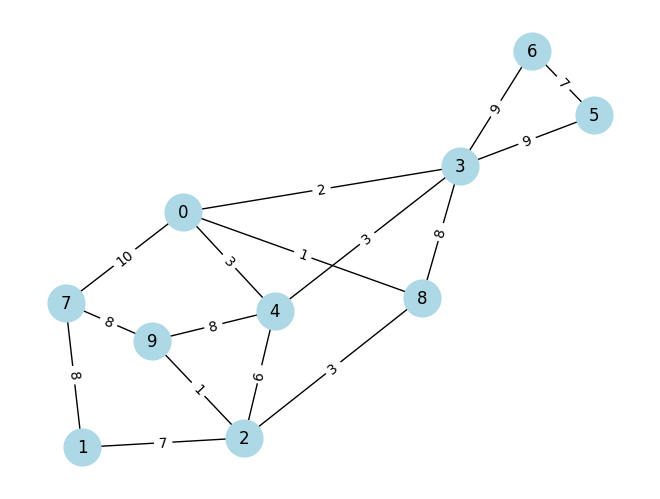

In [3]:
# LECTURA DEL GRAFO
# Para la ruta en caso de MacOs ocupar /, en cualquier otro caso ocupar \
graph_filename = 'Instancias_T3/Grafo.gml' 
G = read_graph_from_file(graph_filename)

# Dibujar el grafo
pos = nx.spring_layout(G, seed = 1)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

#### definí aqui la funcion de grafica solucion pq la necesitaba antes:

In [167]:
def graficar_solucion(G, caminos, s, alpha, beta):
    # Posicionamiento de nodos
    pos = nx.spring_layout(G, seed=1)
    
    plt.figure(figsize=(10, 7))

    # Dibujar grafo base (gris)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, alpha=0.5)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Graficar las rutas óptimas para cables con colores
    M = nx.MultiDiGraph()
    for destino, camino in caminos.items():
        for i in range(len(camino) - 1):
            u, v = camino[i], camino[i + 1]
            peso = G[u][v]['weight']
            M.add_edge(u, v, weight=peso)

    # Asignar colores a cada destino
    colores = plt.cm.rainbow(np.linspace(0, 1, len(caminos)))
    contador = 0

    for color, (destino, camino) in zip(colores, caminos.items()):
        arcos_camino = [(camino[i], camino[i + 1]) for i in range(len(camino) - 1)]

        # Dibujar etiquetas de peso en los arcos
        nx.draw_networkx_edge_labels(
            M, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in arcos_camino}
        )

        # Dibujar los arcos con colores que representan los cables
        for u, v in arcos_camino:
            nx.draw_networkx_edges(
                M, pos, edgelist=[(u, v)], edge_color=[color], width=2,
                connectionstyle=f'arc3,rad={-0.1 * contador}'
            )
        contador += 1

    plt.title(f"Rutas óptimas para alpha = {alpha} y beta = {beta}")
    plt.show()

# Parte I

- $\alpha$: costo del largo total del tubería por distancia $[\frac{costo}{metros}] \rightarrow$ lo multiplico por el largo del árbol de rutas mínimas $\rightarrow$ calculo el costo de usar cada arco del árbol de rutas mínimas y eso lo multiplico por $\alpha$.
- $\beta$: costo del largo total de cables que se instalan $[\frac{costo}{metros}] \rightarrow$ lo multiplico por la suma de los costos de todas las rutas mínimas $\rightarrow$ a cada ruta minima le calculo el costo y eso lo multiplico por $\beta$.

- si $\alpha = 0 \rightarrow$ el unico costo que importa es el costo total de los cables, es decir, el costo total de enviar flujo por todas las rutas mínimas desde la raiz del árbol, en este caso nos conviene hacer **Dijkstra**, pero probando todas las posibles rutas?
- si $\beta = 0 \rightarrow$ el único costo que importa es el costo total de la tubería, es decir, la sumatoría de los costos de los arcos del arbol de rutas mínimas, en este caso nos conviene hacer **Prim**.

In [168]:
def alpha_dist_0(alpha, G):
    AMEM_G = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')
    AMEM_G_costos = sum(d['weight'] for u, v, d in AMEM_G.edges(data=True))

    print(f'Costo total: {AMEM_G_costos*alpha}')
    print(f'Costo tuberías: {AMEM_G_costos*alpha}')
    print(f'Costo cables: 0')
    return AMEM_G

def beta_dist_0(beta, G) -> list:
    # Calculamos todos los caminos más cortos entre pares de nodos usando los pesos
    costos = []

    RM_all_pairs = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

    # Calculamos los costos de los caminos más cortos entre pares de nodos usando los pesos
    RM_all_pairs_costo = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    for source, costs in RM_all_pairs_costo.items():
        costos.append(sum(costs.values()))

    costo_min_index = costos.index(min(costos))              # NODO DEL DICCIONARIO DE RUTAS OPTIMA DE DIJKSTRA QUE TIENE MENOR COSTO TOTAL
    costo_min = sum(RM_all_pairs_costo[costo_min_index].values())

    ruta_optima = RM_all_pairs_costo[costo_min_index]

    print(f'El costo de la solución es {costo_min*beta}')
    print(f'Costo total: {costo_min*beta}')
    print(f'Costo tuberías: 0')
    print(f'Costo cables: {costo_min*beta}')
    
    return RM_all_pairs[costo_min_index]

In [169]:
def elegir_algoritmo(alpha: int, beta: int, G: nx.Graph) -> nx.Graph:
    if type(alpha) is int and type(alpha) is int:
        if alpha>=0 and beta>=0:
            if alpha == 0 and beta == 0:
                print('NO IMPORTA EL COSTO, HAGA LO QUE QUIERA')
            
            elif alpha == 0 and beta != 0:
                return beta_dist_0(beta, G)
            
            elif alpha != 0 and beta == 0:
                return alpha_dist_0(alpha, G)
                
            else:
                print('se resolverá en la parte 2')
        
        elif alpha<0 or beta<0:
            if alpha < 0:
                print(f'Seleccione un valor alpha>0')
        
            else:
                print(f'Seleccione un valor beta>0')
            
    else:
        if type(alpha) is not int:
            print(f'Ingrese un valor numérico para alpha')
        
        else:
            print(f'Ingrese un valor numérico para beta')

In [170]:
def graficar_alpha_0(sol_alpha0: list) -> plt.plot:
    # Creamos un grafo multidigrafo para visualizar arcos paralelos
    M = nx.MultiDiGraph()

    # Añadimos los caminos al MultiDiGraph con arcos paralelos
    for target, path in sol_alpha0.items():
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            weight = G[u][v]['weight']
            M.add_edge(u, v, weight=weight, path=path)

    # Dibujamos el grafo original en gris
    nx.draw(G, pos, with_labels=True, node_color='lightgrey', node_size=700, font_size=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

    # Dibujamos los caminos más cortos desde el nodo 0 en colores distintos para cada destino
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sol_alpha0)))

    cont = 0

    for color, (target, path) in zip(colors, sol_alpha0.items()):
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

        # Etiquetas de los arcos
        nx.draw_networkx_edge_labels(M, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in path_edges})

        # Desplazamiento para arcos paralelos
        for i, (u, v) in enumerate(path_edges):
            nx.draw_networkx_edges(M, pos, edgelist=[(u, v)], edge_color=[color], width=2,
                                        connectionstyle='arc3,rad='+str(-0.1*cont))    
        cont +=1

    plt.show()

In [171]:
def graficar_arbol_beta_0(sol: nx.Graph):
    # Minimum spanning tree = AMEM
    #sol = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')

    pos = nx.spring_layout(G, seed = 1)

    nx.draw(sol, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=15)
    nx.draw_networkx_edge_labels(sol, pos, edge_labels={(u, v): d['weight'] for u, v, d in sol.edges(data=True)})
    plt.title('Árbol de rutas mínimas de G')
    plt.show()

def graficar_beta_0(sol: nx.Graph, alpha):
    arcos_amem = nx.minimum_spanning_edges(sol, algorithm='prim', weight='weight')
    arbol_amem = nx.Graph()
    arbol_amem.add_edges_from(arcos_amem)

    rutas = dict()
    for t in list(G.nodes()):
        rutas[t]=nx.shortest_path(arbol_amem, 0, t)     # 0 es el nodo de origen
    graficar_solucion(G, rutas, 0,alpha, 0)         

#### Probamos para los 4 casos posibles

##### $\alpha = 0$, $\beta=0$

In [172]:
alpha = 0
beta = 0

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol)

elif alpha>0 and beta>0:
    print('solucion de la parte 2')

NO IMPORTA EL COSTO, HAGA LO QUE QUIERA


##### $\alpha = 0$, $\beta\neq0$

El costo de la solución es 58
Costo total: 58
Costo tuberías: 0
Costo cables: 58


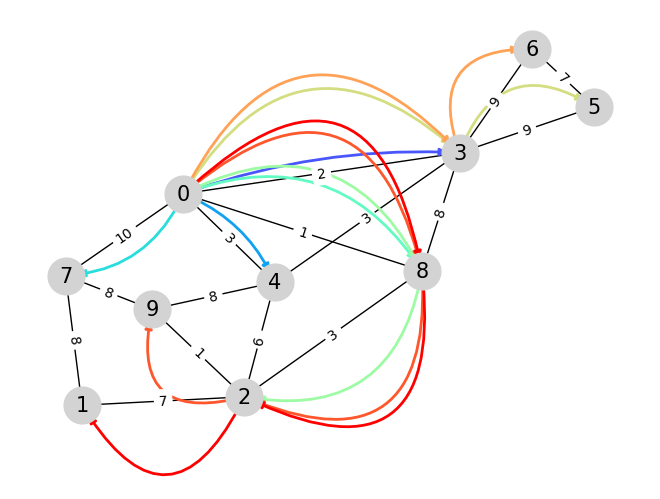

In [173]:
alpha = 0
beta = 1

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol)

else:
    print('solucion de la parte 2')

##### $\alpha \neq 0$, $\beta=0$

Costo total: 41
Costo tuberías: 41
Costo cables: 0


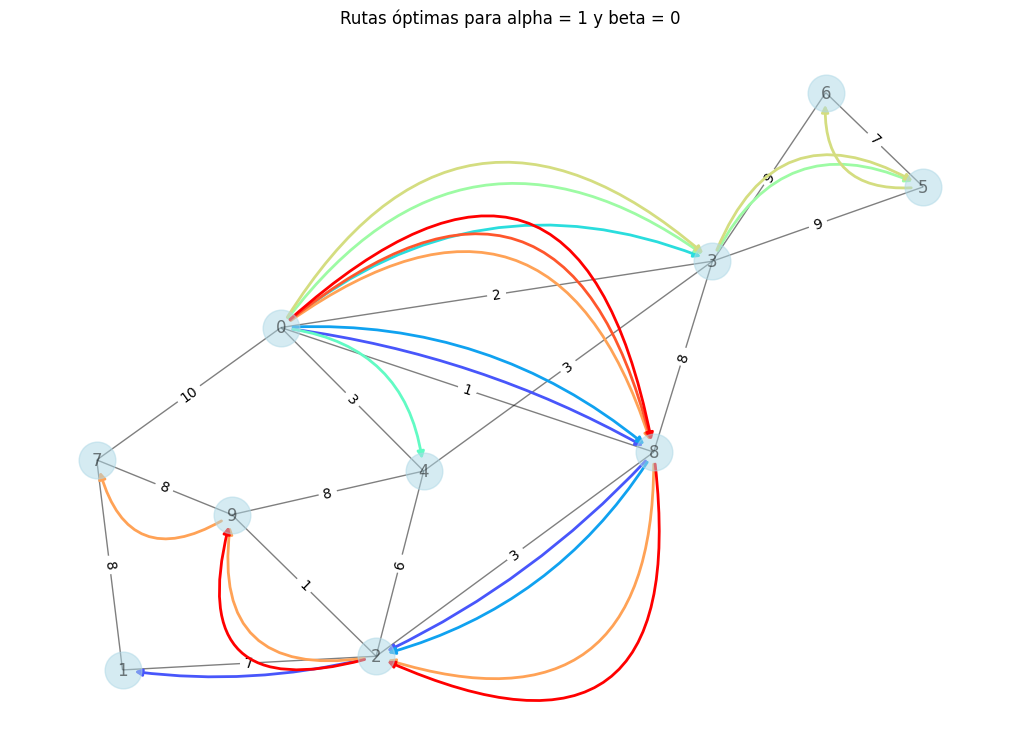

In [174]:
alpha = 1
beta = 0

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol, alpha)

else:
    print('solucion de la parte 2')

##### $\alpha \neq 0$, $\beta\neq0$

In [175]:
alpha = 1
beta = 1

sol = elegir_algoritmo(alpha, beta, G)


se resolverá en la parte 2


# Parte II

### Pura heuristica

LO MEJOR Q PUDE HACER DSO DE ESTAR TODO EL DIA PENSANDOLO

In [100]:
def calcular_costos(G, alpha, beta, s):
    destinos = [nodo for nodo in G.nodes if nodo != s]  # Todos los nodos distintos a s
    
    cto_tuberias = 0
    cto_cables = 0
    arcos_tuberias = set()
    arcos_cables = list()
    caminos = {}
    
    for t in destinos:
        visitados = {s}
        nodo_actual = s
        camino = [nodo_actual]
        
        while nodo_actual != t:
            vecinos = [(vecino, G[nodo_actual][vecino]['weight']) 
                       for vecino in G.neighbors(nodo_actual) 
                       if vecino not in visitados]
            
            primeros = [elemento[0] for elemento in vecinos]
            
            if t in primeros:
                arcos_tuberias.add((nodo_actual, t))
                arcos_cables.append((nodo_actual, t))
                nodo_actual = t
                visitados.add(nodo_actual)
                camino.append(nodo_actual)
                break
            
            if not vecinos:
                print(f"No se puede llegar al destino {t} desde el nodo actual.")
                break
            
            vecino_mas_cercano = min(vecinos, key=lambda x: x[1])[0]

            # con el siguiente pedazo de codigo la solucion se va a la mierda
            '''mejores = []
            for a in vecinos:
                if (nodo_actual,a[0]) in arcos_tuberias:
                    mejores.append(a)
                    

            if len(mejores)!=0:
                vecino_mas_cercano = min(mejores, key=lambda x: x[1])[0]'''
            
            # Avanza al vecino más cercano
            arcos_tuberias.add((nodo_actual, vecino_mas_cercano))
            arcos_cables.append((nodo_actual, vecino_mas_cercano))
            nodo_actual = vecino_mas_cercano
            visitados.add(nodo_actual)
            camino.append(nodo_actual)
        
        caminos[t] = camino
    
    for arcos in arcos_cables:
        cto_cables += G.get_edge_data(arcos[0], arcos[1])['weight'] * beta

    for arcos in arcos_tuberias:
        cto_tuberias += G.get_edge_data(arcos[0], arcos[1])['weight'] * alpha

    costo_total= cto_cables + cto_tuberias

    return costo_total, cto_tuberias, cto_cables, caminos


In [101]:
calcular_costos(G, 159.7, 1, 0)

(9029.2,
 8943.2,
 86,
 {1: [0, 8, 2, 1],
  2: [0, 8, 2],
  3: [0, 3],
  4: [0, 4],
  5: [0, 8, 2, 9, 4, 3, 5],
  6: [0, 8, 2, 9, 4, 3, 6],
  7: [0, 7],
  8: [0, 8],
  9: [0, 8, 2, 9]})

### Mejor algoritmo (agustina soy tu fan)

In [106]:
def calcular_costos2(G, alpha, beta, s):
    #inicializamos distancias en infinito y predecesores en -
    distancias = {nodo: float('inf') for nodo in G.nodes}
    previos = {nodo: None for nodo in G.nodes}
    distancias[s] = 0  # Distancia inicial al nodo central

    #cola de prioridad para explorar los nodos más cercanos
    cola_prioridad = [(0, s)]  # (distancia acumulada, nodo)

    while cola_prioridad:
        distancia_actual, nodo_actual = heapq.heappop(cola_prioridad)

        #si la distancia es mas larga que la que ya tenemos, chao
        if distancia_actual > distancias[nodo_actual]:
            continue

        #revisamos los vecinos del nodo actual en el que estamos parados
        for vecino in G.neighbors(nodo_actual):
            peso_arista = G[nodo_actual][vecino]['weight']
            nueva_distancia = distancia_actual + peso_arista

            #se actualiza la label de distancia si encontramos un camino más corto
            if nueva_distancia < distancias[vecino]:
                distancias[vecino] = nueva_distancia
                previos[vecino] = nodo_actual
                heapq.heappush(cola_prioridad, (nueva_distancia, vecino))

    #recuperamos los caminos desde el origen hacia cada nodo
    caminos = {}
    for destino in G.nodes:
        if destino == s:  #nodo central chao pq la ruta es nula
            continue
        camino = []
        nodo_actual = destino
        while nodo_actual is not None:
            camino.append(nodo_actual)
            nodo_actual = previos[nodo_actual]
        caminos[destino] = camino[::-1]  #invertimos el camino para origen -> destino

    #calculamos los costos
    cto_tuberias = 0
    cto_cables = 0

    #encontrar solo los arcos únicos (para costo de tuberías)
    arcos_utilizados = set()
    for destino, camino in caminos.items():
        for i in range(len(camino) - 1):  #recorro las aristas del camino
            nodo_a, nodo_b = camino[i], camino[i + 1]
            arcos_utilizados.add((min(nodo_a, nodo_b), max(nodo_a, nodo_b)))  

    # sumar los costos de los arcos utilizados (tuberías)
    for u, v in arcos_utilizados:
        cto_tuberias += G[u][v]['weight']

    # costo de los cables: directamente desde el nodo central a cada nodo, ver cuantas veces se utiliza cada arco
    for destino in G.nodes:
        if destino == s:
            continue
        cto_cables += distancias[destino]

    #print(f"Costo de las tuberías sin multiplicar por alpha: {cto_tuberias}")
    #print(f"Costo de los cables sin multiplicar por beta: {cto_cables}")
    
    #costos totales según los factores alpha y beta
    #print(f"Costo de las tuberías multiplicando por alpha: {cto_tuberias*alpha}")
    #print(f"Costo de los cables multiplicando por beta: {cto_cables*beta}")
    costo_total = cto_tuberias * alpha + cto_cables * beta
    #print(f"Costo total de la solución: {costo_total}")

    return costo_total, cto_tuberias * alpha, cto_cables * beta, caminos






In [108]:
alphas = [0, 0.1, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4, 5.5, 8.9, 14.4, 23.3, 37.7, 61.0, 98.7, 159.7]
betas = [1]

for a in alphas:
    if calcular_costos(G, a, 1, 0)[1] < calcular_costos2(G, a, 1, 0)[1]:
        print(calcular_costos(G, a, 1, 0))
        print(calcular_costos2(G, a, 1, 0))
    

In [23]:
costo_total, cto_tuberias, cto_cables, caminos = calcular_costos2(G, 0.1, 1, 0)

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 4.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 62.5


In [20]:
calcular_costos2(G, 159.7, 1, 0)

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 7186.499999999999
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 7244.499999999999


(7244.499999999999,
 7186.499999999999,
 58,
 {1: [0, 8, 2, 1],
  2: [0, 8, 2],
  3: [0, 3],
  4: [0, 4],
  5: [0, 3, 5],
  6: [0, 3, 6],
  7: [0, 7],
  8: [0, 8],
  9: [0, 8, 2, 9]})

In [ ]:
def graficar_solucion(G, caminos, s, alpha, beta):
    # Posicionamiento de nodos
    pos = nx.spring_layout(G, seed=1)
    
    plt.figure(figsize=(10, 7))

    # Dibujar grafo base (gris)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, alpha=0.5)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Graficar las rutas óptimas para cables con colores
    M = nx.MultiDiGraph()
    for destino, camino in caminos.items():
        for i in range(len(camino) - 1):
            u, v = camino[i], camino[i + 1]
            peso = G[u][v]['weight']
            M.add_edge(u, v, weight=peso)

    # Asignar colores a cada destino
    colores = plt.cm.rainbow(np.linspace(0, 1, len(caminos)))
    contador = 0

    for color, (destino, camino) in zip(colores, caminos.items()):
        arcos_camino = [(camino[i], camino[i + 1]) for i in range(len(camino) - 1)]

        # Dibujar etiquetas de peso en los arcos
        nx.draw_networkx_edge_labels(
            M, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in arcos_camino}
        )

        # Dibujar los arcos con colores que representan los cables
        for u, v in arcos_camino:
            nx.draw_networkx_edges(
                M, pos, edgelist=[(u, v)], edge_color=[color], width=2,
                connectionstyle=f'arc3,rad={-0.1 * contador}'
            )
        contador += 1

    plt.title(f"Rutas óptimas para alpha = {alpha} y beta = {beta}")
    plt.show()


Evaluando archivo: Parte 2 - Instancia 1.txt
Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 45
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 103
Alpha: 1, Beta: 1, Costo total: 103


C:\Users\cater\AppData\Local\Temp\ipykernel_5184\3285278218.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


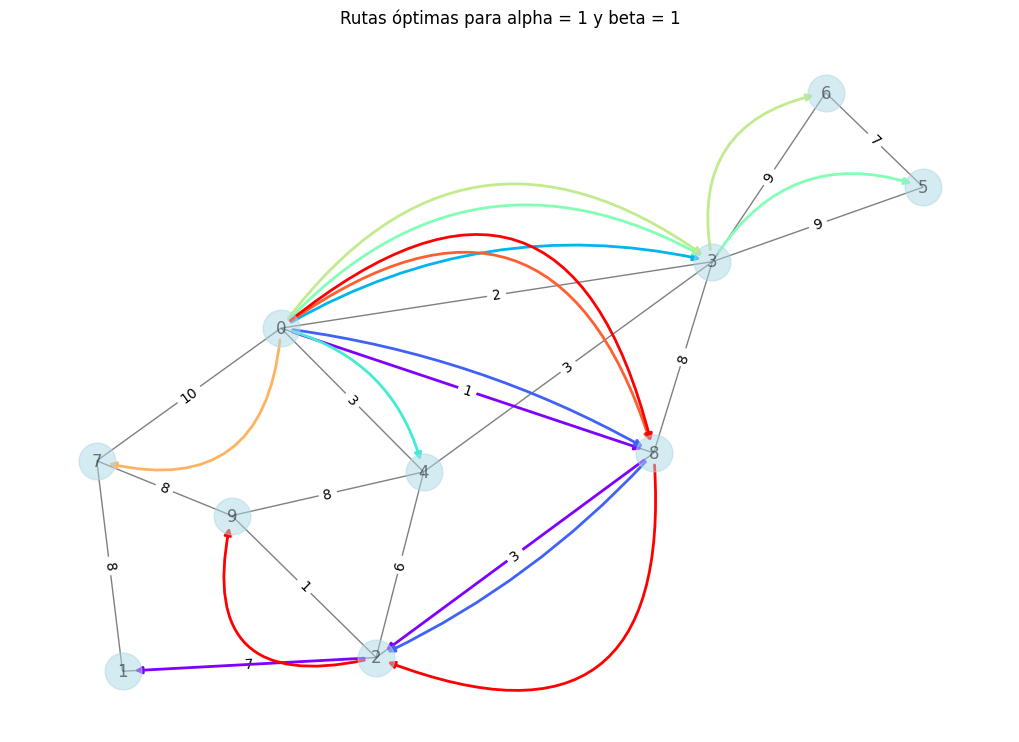


Evaluando archivo: Parte 2 - Instancias 2.txt
Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 58
Alpha: 0, Beta: 1, Costo total: 58


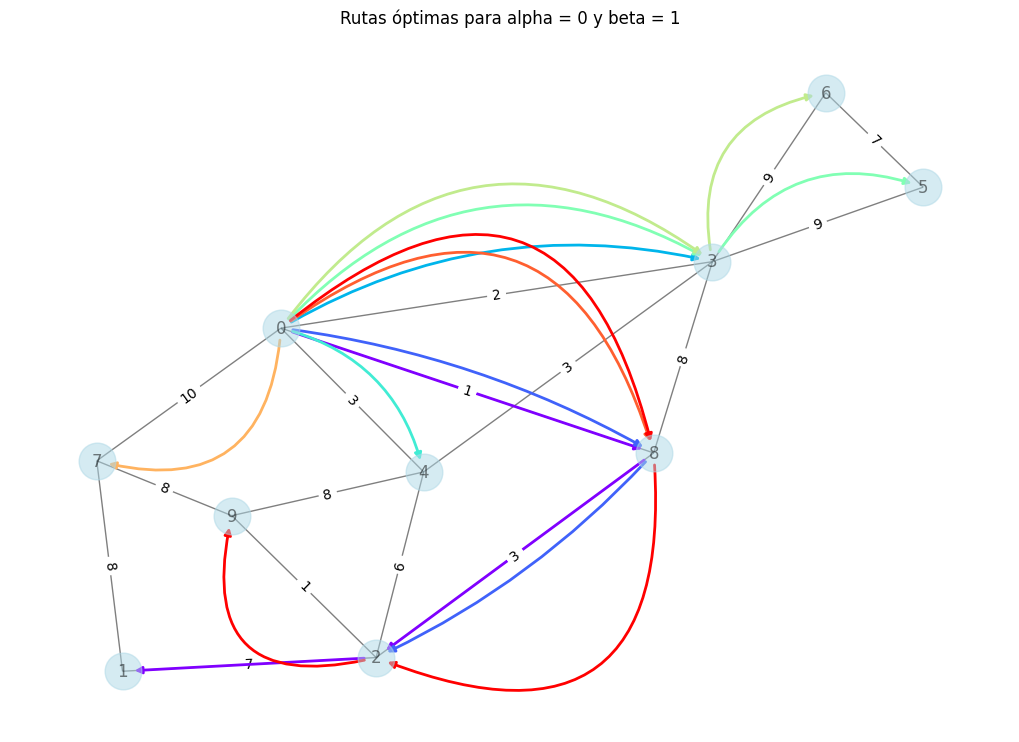

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 4.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 62.5
Alpha: 0.1, Beta: 1, Costo total: 62.5


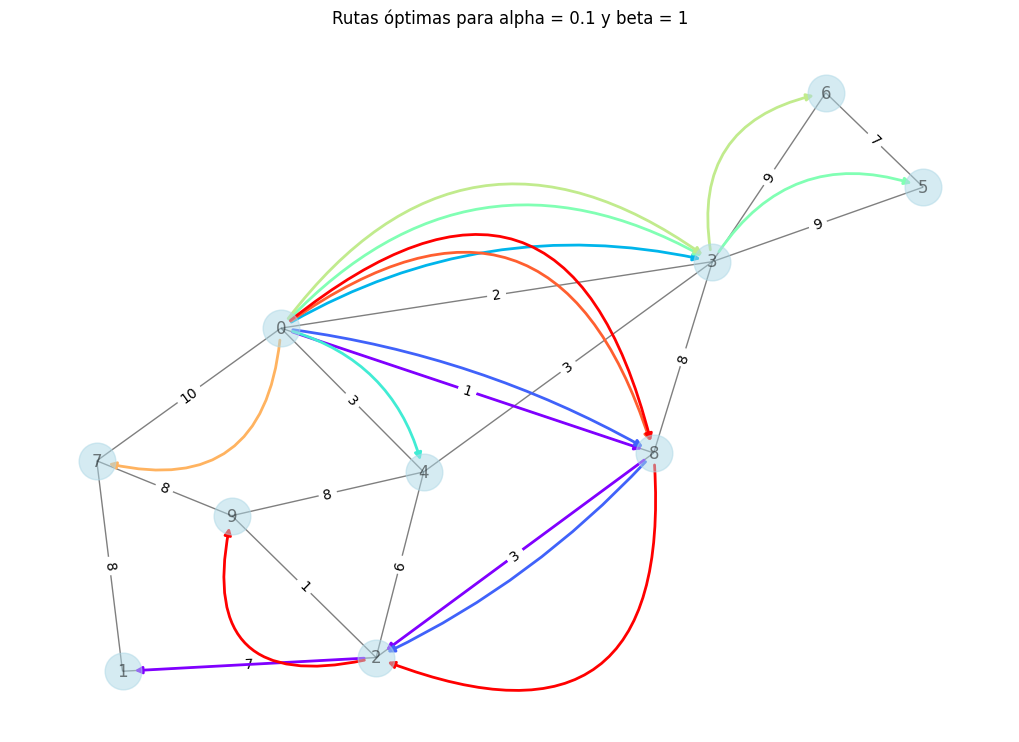

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 4.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 62.5
Alpha: 0.1, Beta: 1, Costo total: 62.5


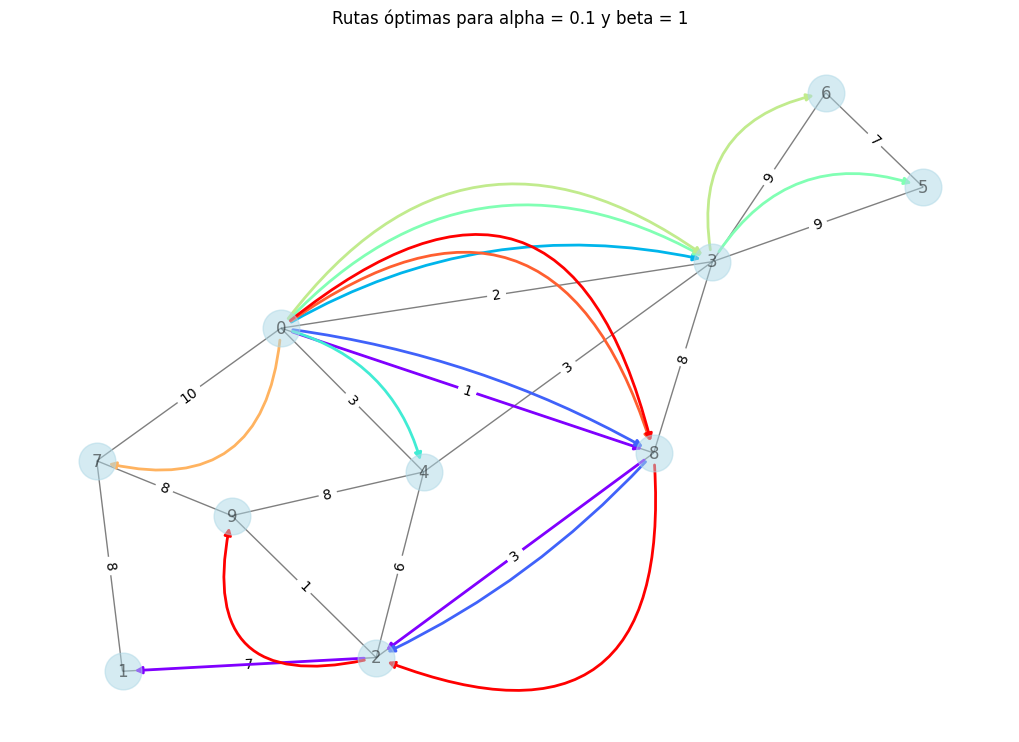

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 9.0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 67.0
Alpha: 0.2, Beta: 1, Costo total: 67.0


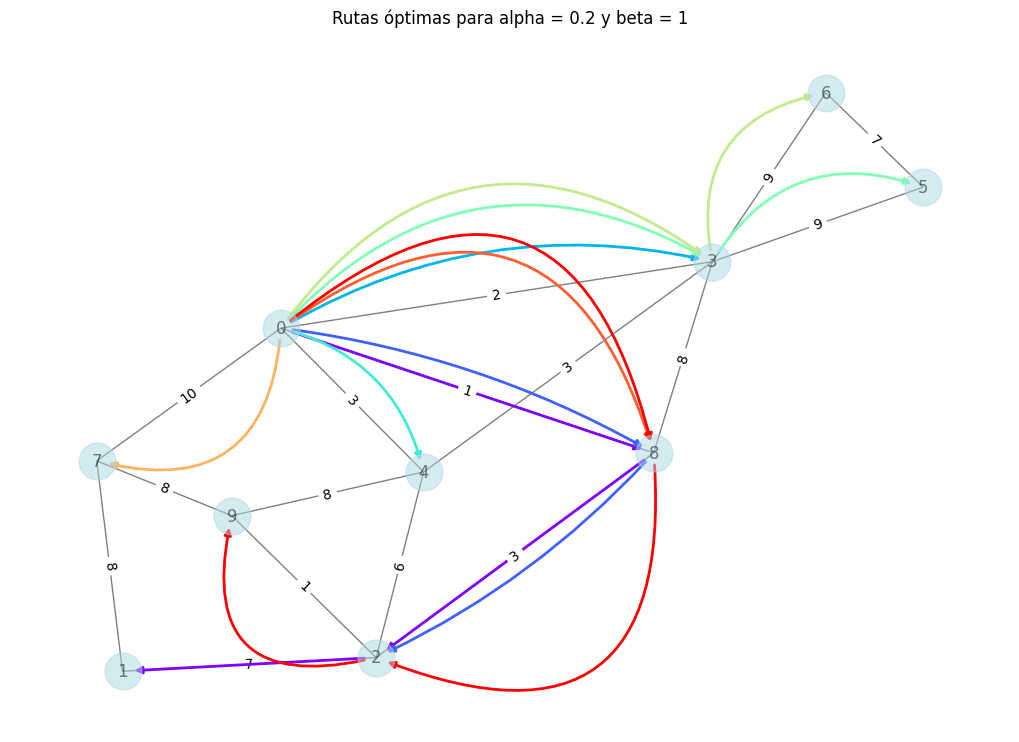

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 13.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 71.5
Alpha: 0.3, Beta: 1, Costo total: 71.5


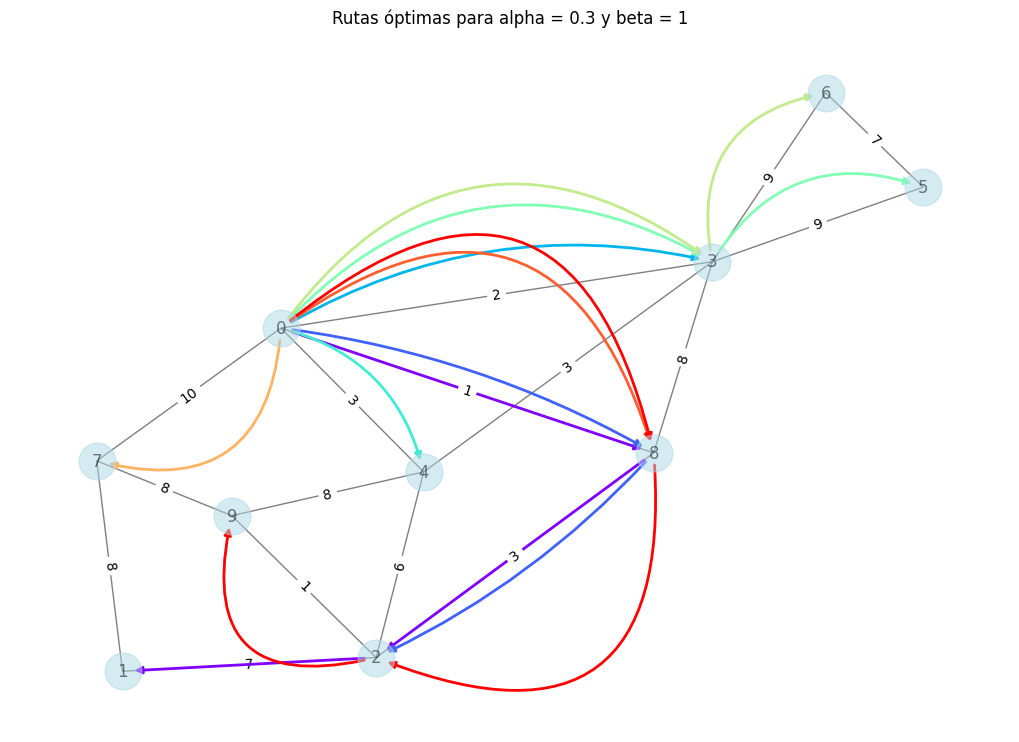

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 22.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 80.5
Alpha: 0.5, Beta: 1, Costo total: 80.5


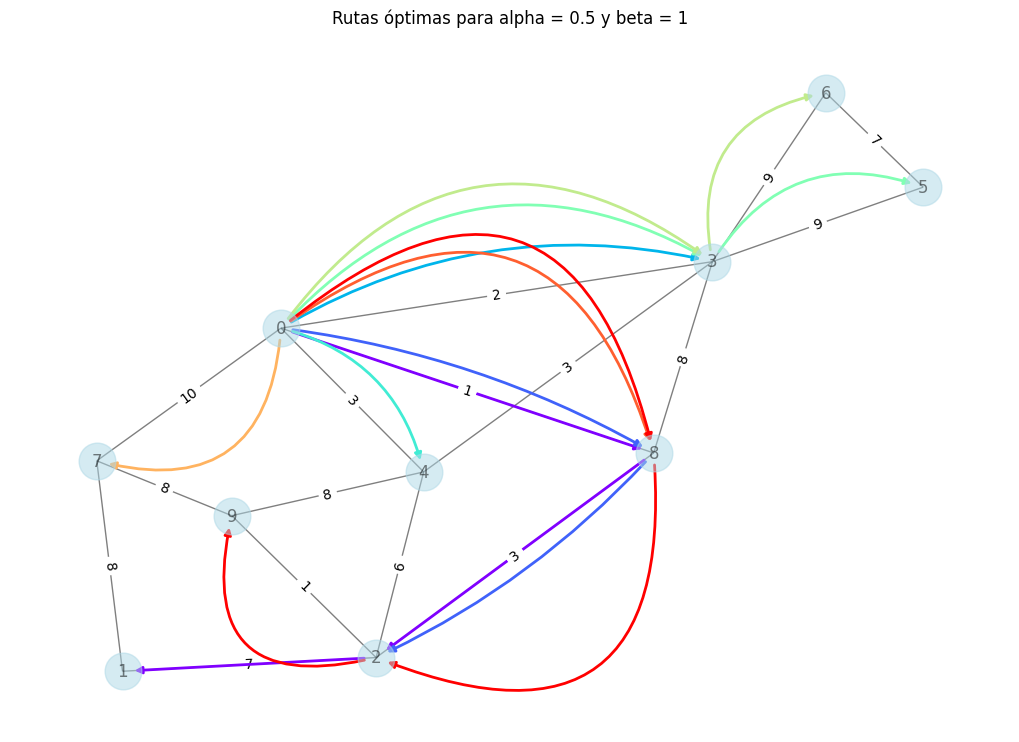

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 36.0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 94.0
Alpha: 0.8, Beta: 1, Costo total: 94.0


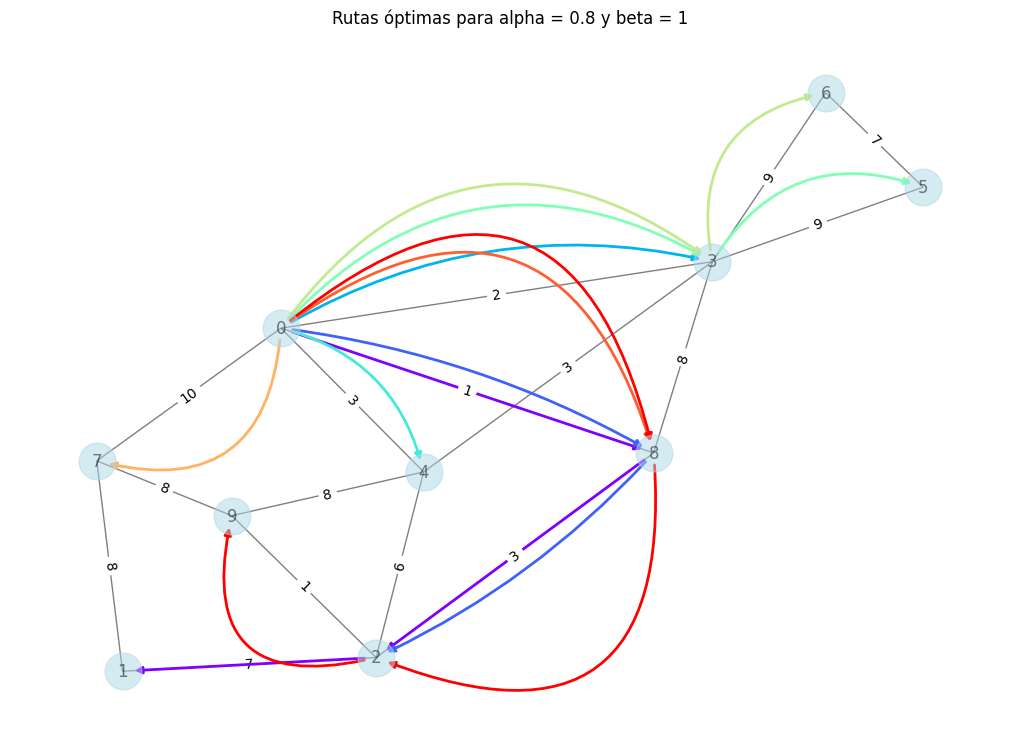

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 58.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 116.5
Alpha: 1.3, Beta: 1, Costo total: 116.5


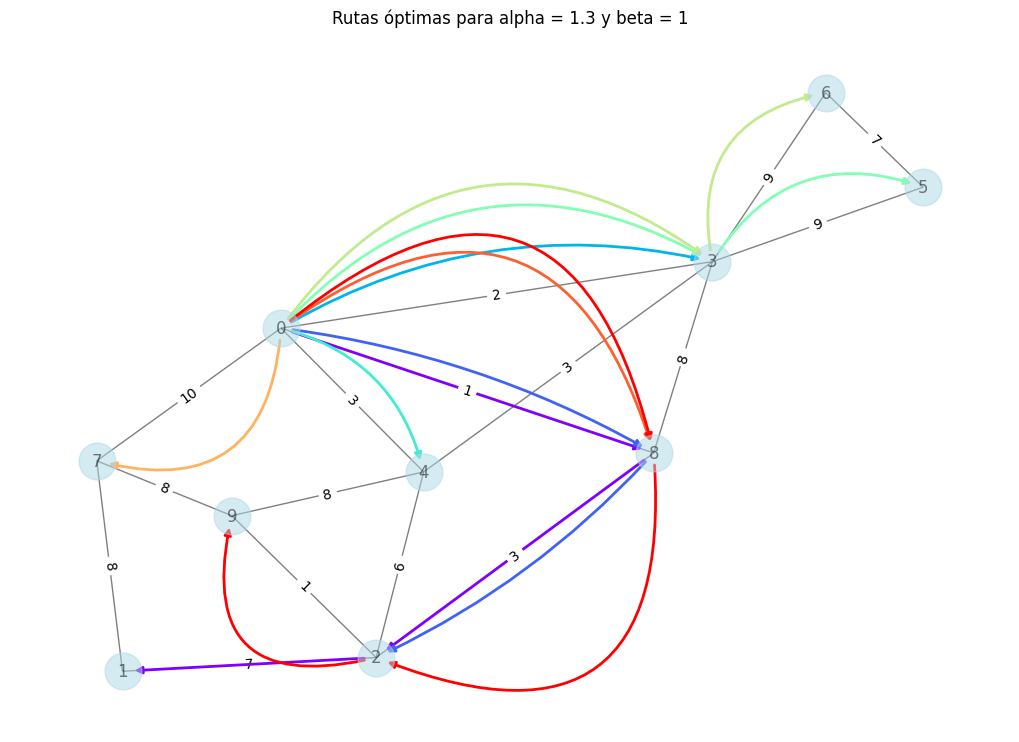

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 94.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 152.5
Alpha: 2.1, Beta: 1, Costo total: 152.5


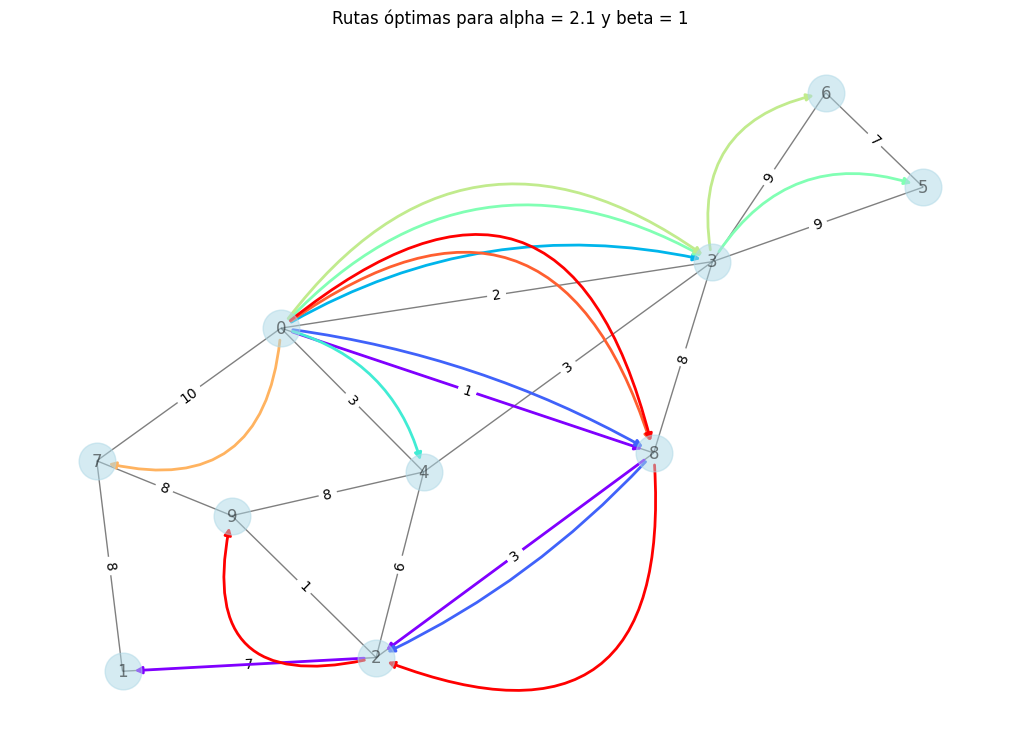

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 153.0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 211.0
Alpha: 3.4, Beta: 1, Costo total: 211.0


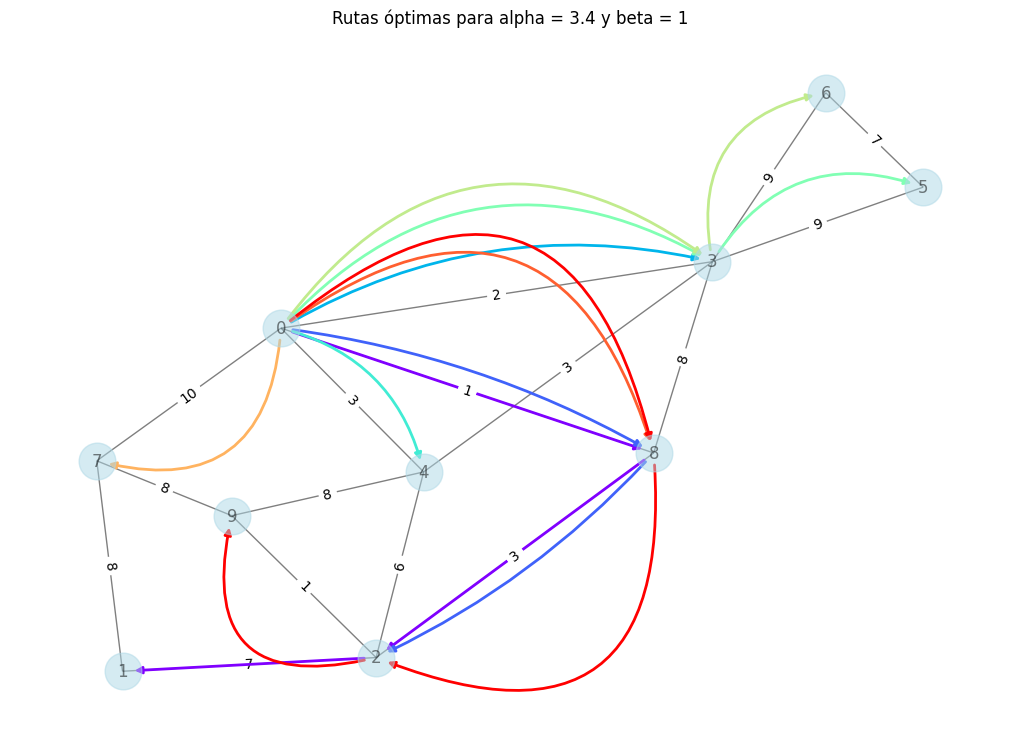

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 247.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 305.5
Alpha: 5.5, Beta: 1, Costo total: 305.5


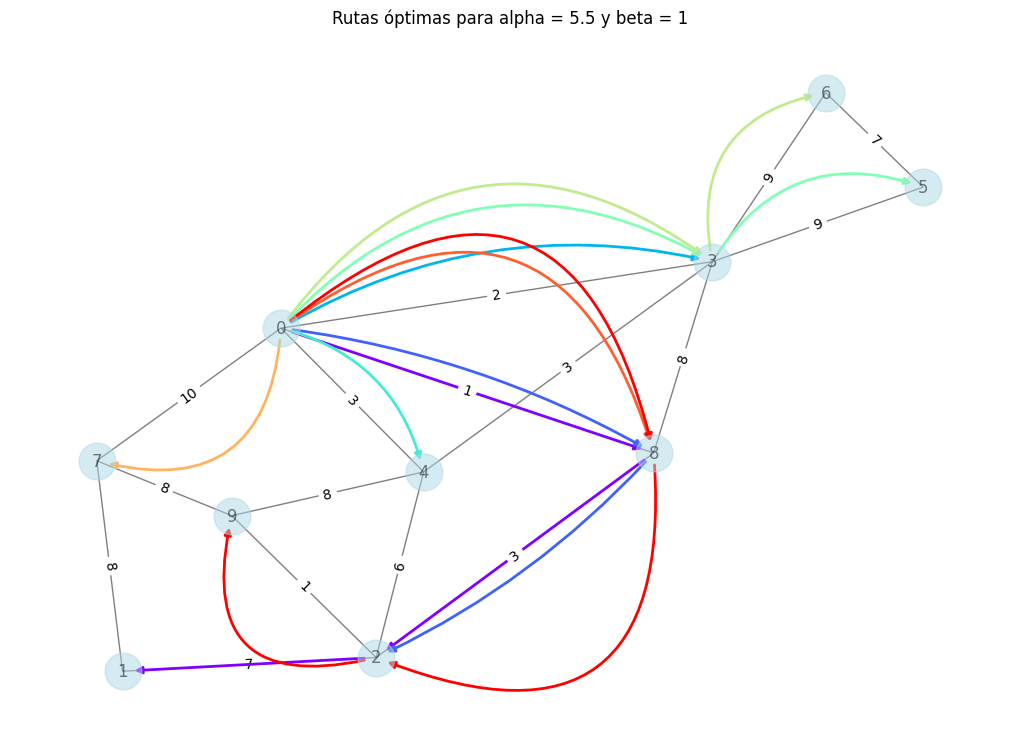

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 400.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 458.5
Alpha: 8.9, Beta: 1, Costo total: 458.5


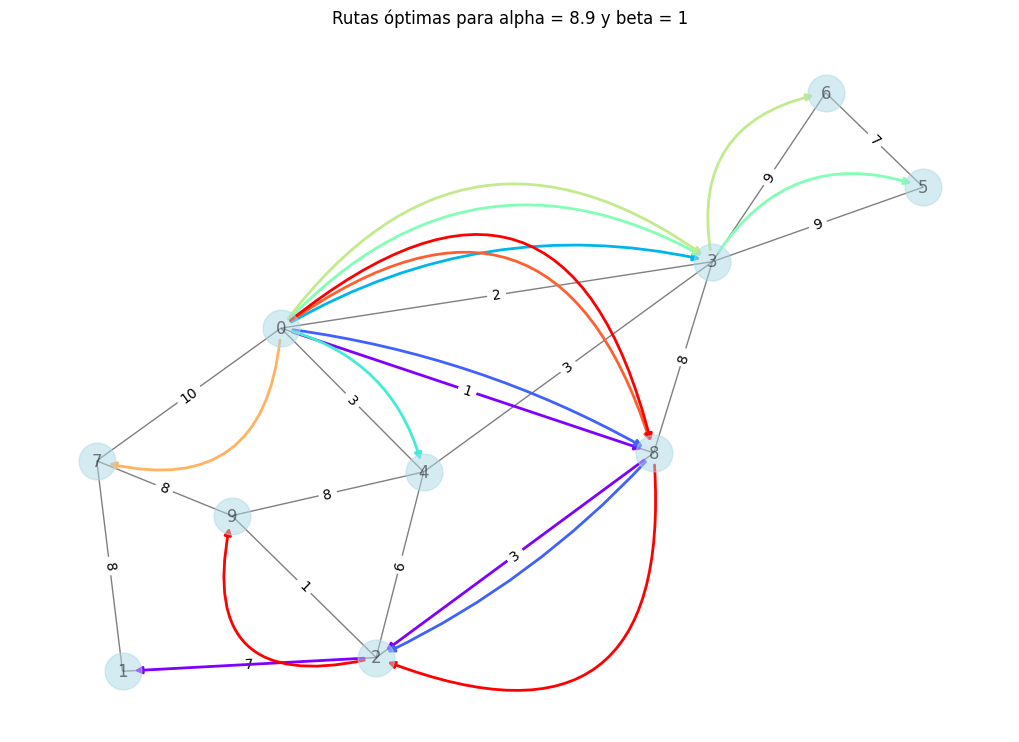

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 648.0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 706.0
Alpha: 14.4, Beta: 1, Costo total: 706.0


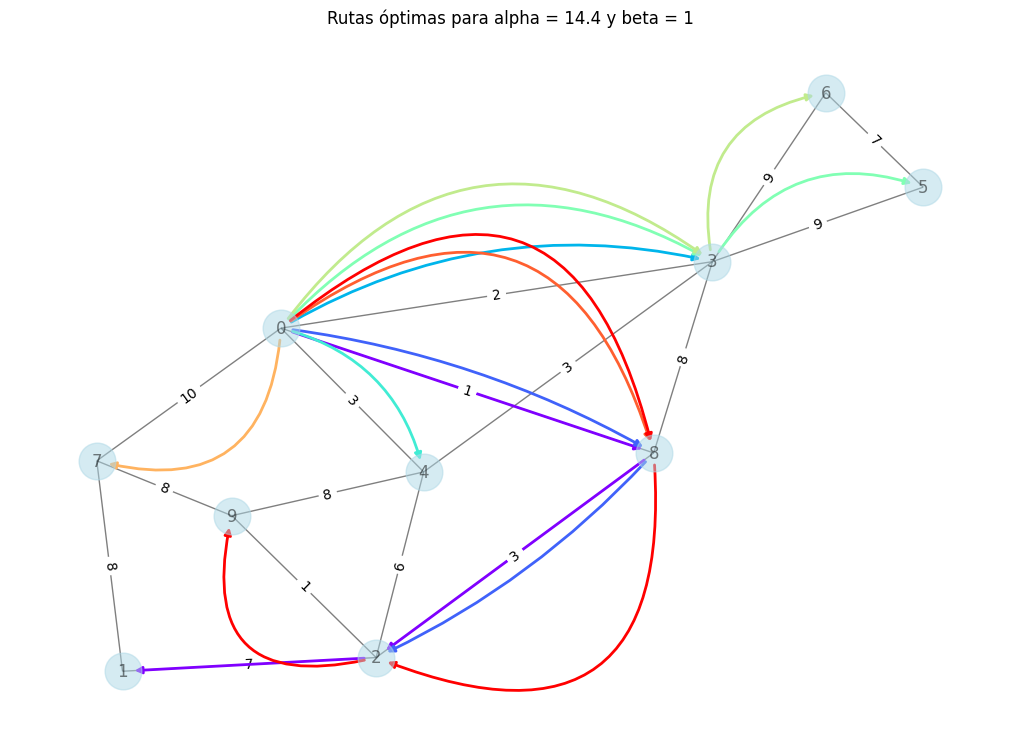

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 1048.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 1106.5
Alpha: 23.3, Beta: 1, Costo total: 1106.5


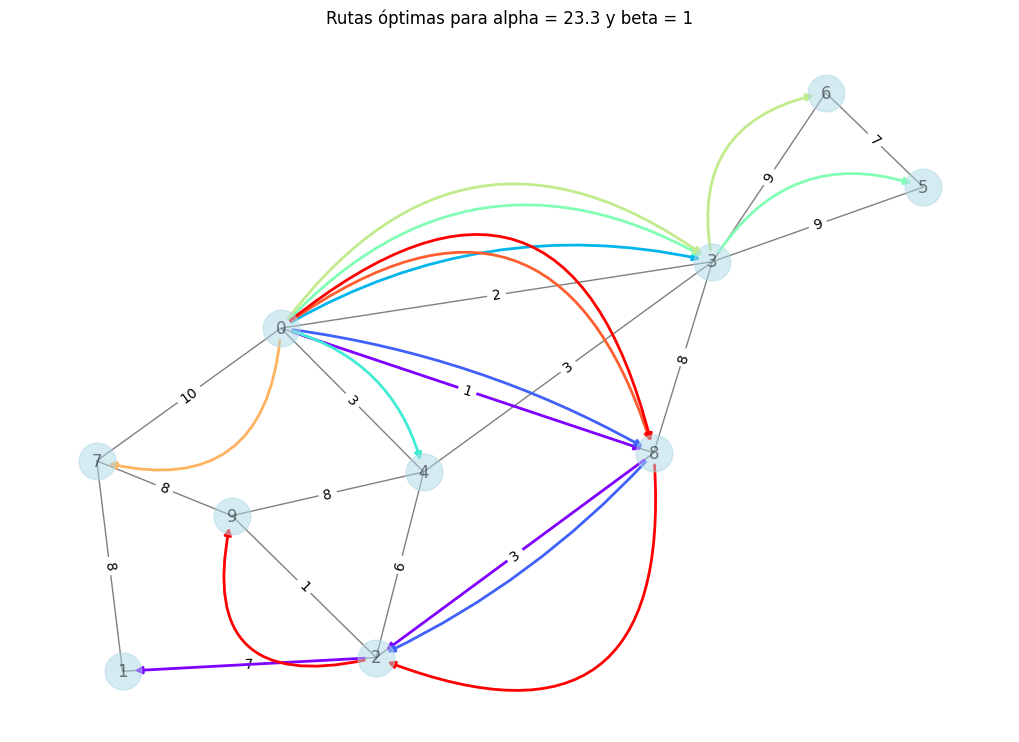

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 1696.5000000000002
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 1754.5000000000002
Alpha: 37.7, Beta: 1, Costo total: 1754.5000000000002


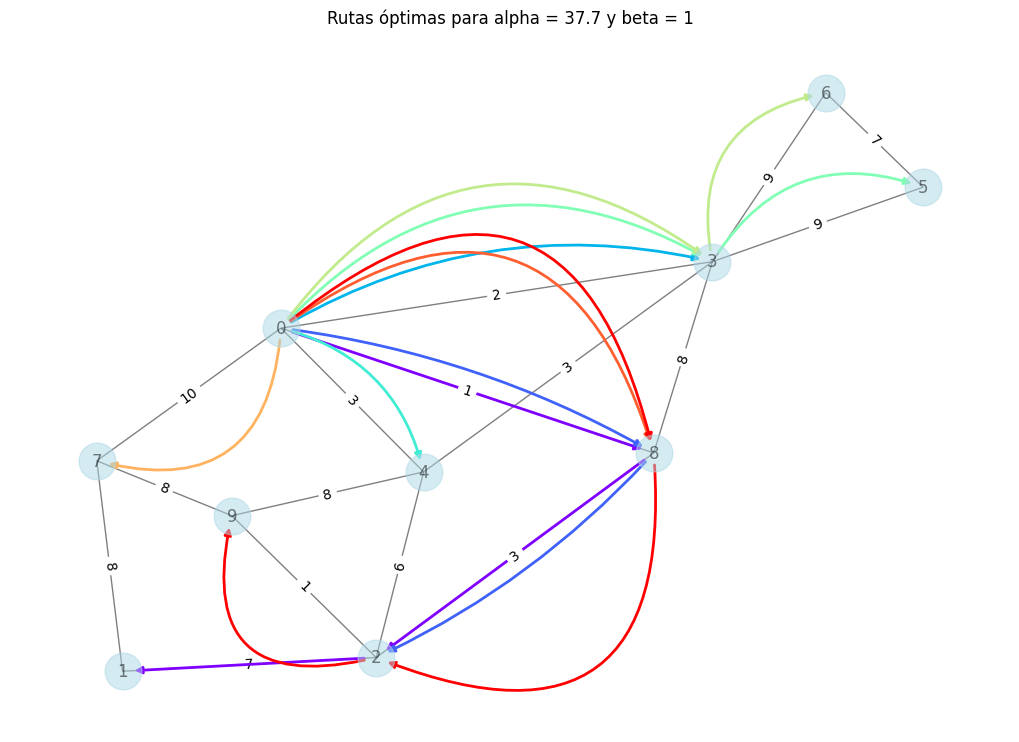

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 2745.0
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 2803.0
Alpha: 61.0, Beta: 1, Costo total: 2803.0


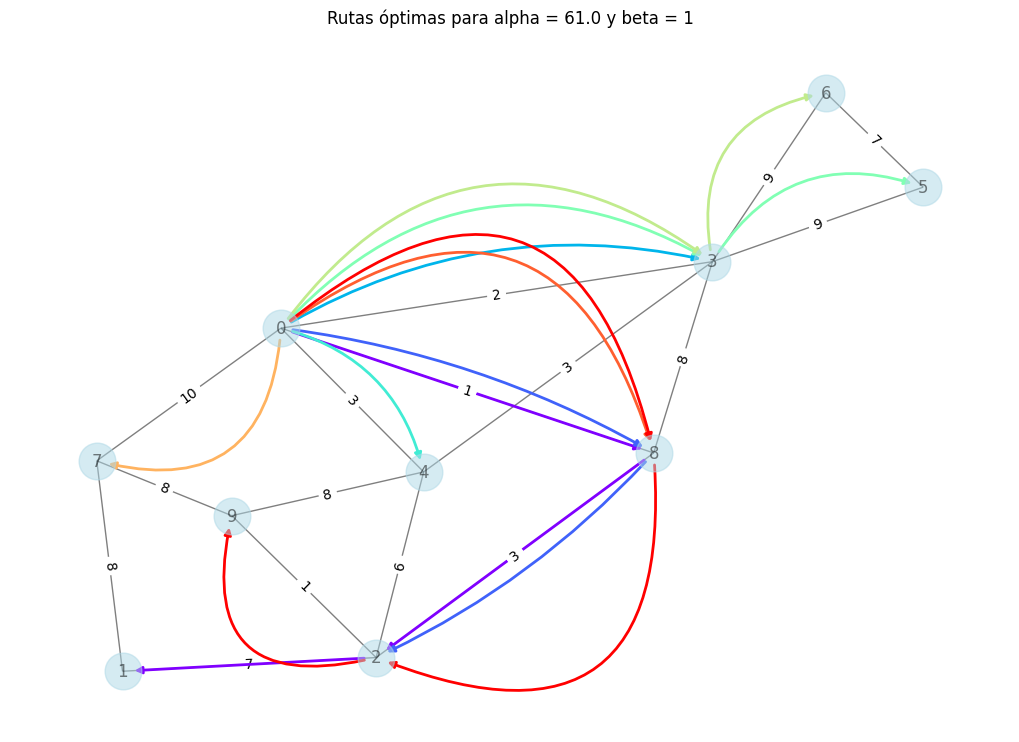

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 4441.5
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 4499.5
Alpha: 98.7, Beta: 1, Costo total: 4499.5


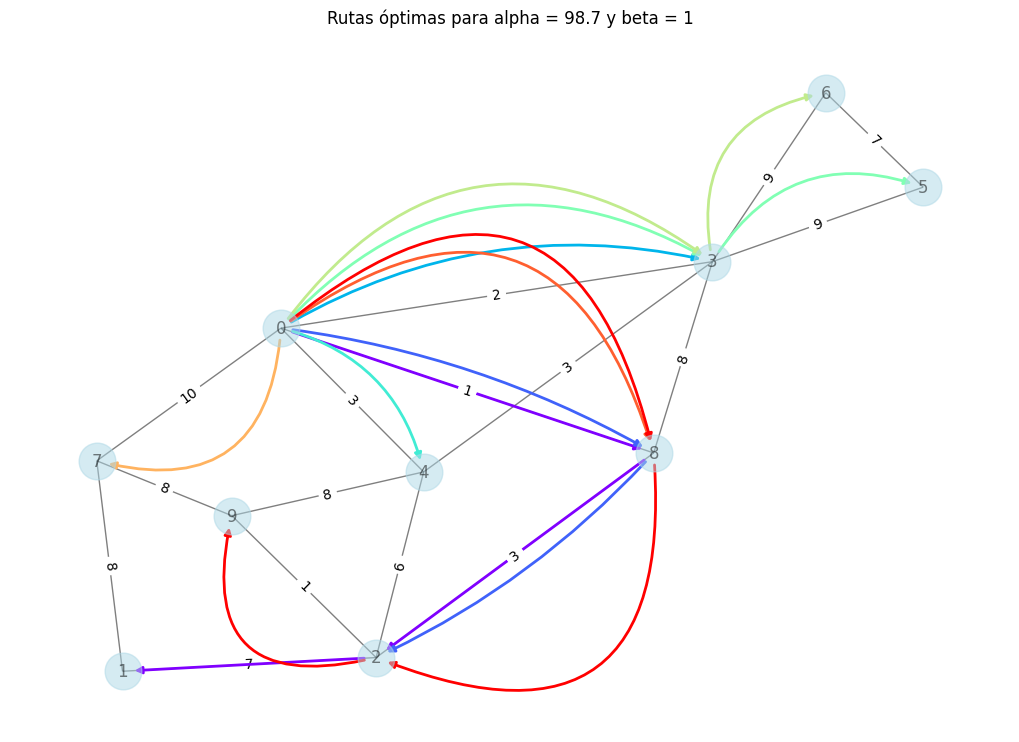

Costo de las tuberías sin multiplicar por alpha: 45
Costo de los cables sin multiplicar por beta: 58
Costo de las tuberías multiplicando por alpha: 7186.499999999999
Costo de los cables multiplicando por beta: 58
Costo total de la solución: 7244.499999999999
Alpha: 159.7, Beta: 1, Costo total: 7244.499999999999


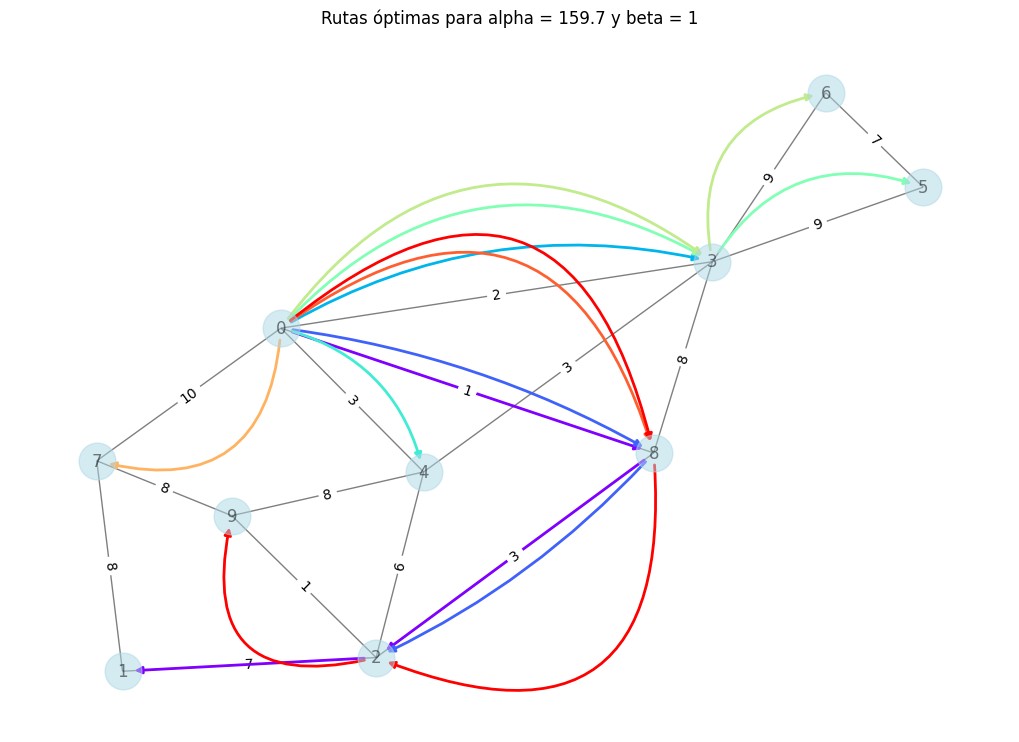

In [22]:
def leer_instancias_y_evaluar(ruta_carpeta, archivos_instancias, G, nodo_central):
    for archivo in archivos_instancias:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        with open(ruta_archivo, 'r') as f:
            contenido = f.read()
        # Extraer valores de alpha y beta
        alphas = eval(contenido.split('alphas = ')[1].split('\n')[0])
        betas = eval(contenido.split('betas = ')[1].split('\n')[0])
        print(f"\nEvaluando archivo: {archivo}")
        for alpha in alphas:
            for beta in betas:
                costo_total, costo_tuberias, costo_cables, caminos = calcular_costos2(G, alpha, beta, nodo_central)
                print(f"Alpha: {alpha}, Beta: {beta}, Costo total: {costo_total}")
                graficar_solucion(G, caminos, nodo_central, alpha, beta)

# Configuración
ruta_carpeta = "Instancias_T3"
archivos_instancias = ["Parte 2 - Instancia 1.txt", "Parte 2 - Instancias 2.txt"]


# Llamar a la función principal
leer_instancias_y_evaluar(ruta_carpeta, archivos_instancias, G, 0)

